In [1]:
import nibabel as nib
import os
import numpy as np
from scipy.stats import norm

wth05_n20 = '/Volumes/camille/IBMA_simu/test1_k025_n20_btw1_wth05_nominal/0001/megaMFX/'
wthdiff_n20 = '/Volumes/camille/IBMA_simu/test1_k025_n20_btw1_wthdiff_nominal/0001/megaMFX/'
z_05 = nib.load(os.path.join(wth05_n20, 'stats', 'zstat1.nii.gz')).get_data().flatten()
z_diff = nib.load(os.path.join(wthdiff_n20, 'stats', 'zstat1.nii.gz')).get_data().flatten()

import pandas as pd
import matplotlib.pyplot as plt


import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import scipy.stats

def distribution_plot(title, data, dist, *args, **kwargs):
    np.random.seed(0)
    num_bins = 100
    

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10,5))

    # histogram plot
    n, bins, patches = ax1.hist(data, num_bins, normed=1)
    y = dist.pdf(bins, *args)       
    ax1.plot(bins, y, '-')
    ax1.set_title(title)
    
    # qq-plot plot
    p_th = [t/data.size for t in range(1,data.size+1)]

    line1, = ax2.loglog(p_th, sorted(dist.sf(data, *args)), '.', linewidth=1,
                     label=title)
    ax2.plot(p_th, p_th, '-')
    ax2.set_title('Q-Q plot')


    ax2.legend(loc='lower right')
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.show()

### Problem statement

GLM MFX invalidity with varying within-study variance as illustrated in the Q-Q plot below.

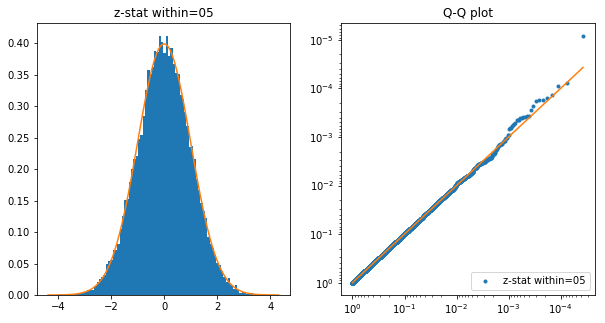

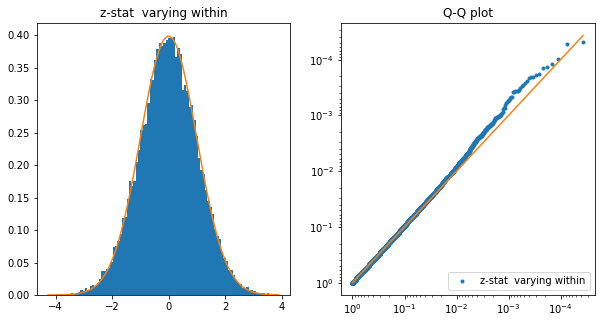

In [2]:
def z_distribution_plot(data, title, *args, **kwargs):   
    distribution_plot(title, data, scipy.stats.norm)
    
z_distribution_plot(z_05, 'z-stat within=05')
z_distribution_plot(z_diff, 'z-stat  varying within')

In [3]:
n = 20;
k = 25;
copes = dict()
varcopes = dict()
sigma2 = 0.5

for i in ['05']:
    key = 'wth' + str(i) + '_k' + str(k) + '_n' + str(n)
    print('key is \'' + key + '\'')
    study_dir = '/Volumes/camille/IBMA_simu/test1_k0' + str(k) + '_n' + str(n) + '_btw1_wth' + str(int(0.5*n)) + '_nominal/0001/megaMFX/'
    copes[key] = nib.load(os.path.join(study_dir, 'cope.nii.gz')).get_data().reshape(-1,k)
    varcopes[key] = nib.load(os.path.join(study_dir, 'varcope.nii.gz')).get_data().reshape(-1,k)

# Check mean/variance of input copes
print('Mean of study 1 cope = ' + str(np.mean(copes['wth05_k25_n20'][:,1].flatten())))
print('Variance of study 1 cope = ' + str(np.var(copes['wth05_k25_n20'][:,1].flatten())))

key is 'wth05_k25_n20'
Mean of study 1 cope = 0.00411488
Variance of study 1 cope = 1.52046


### Identified issue

Issue: the within-study variance in the cope values of study 1 should be 0.5 not 1.5. 


This problem arises from the fact that cope was simulated with:
```
% Simulated paramater estimate
pe = normrnd(0, sqrt(wth_sigma2*a./n+btw_sigma2), [30 30 30]);
```
rather than:
```
% Study-specific mean effect
study_mean = normrnd(0, sqrt(btw_sigma2));

% Simulated paramater estimate
pe = normrnd(study_mean, sqrt(wth_sigma2*a./n), [30 30 30]);
```

This issue was solved in https://github.com/cmaumet/zmeta_buster/commit/67d2f00517b67a940df03d1076b969c92428db13.

=> This fix is problematic because voxels are no longer independent which means that we cannot compute the MC distribution on the zstat1.nii.gz map.

### Updated plots (after fix) => PROBLEM

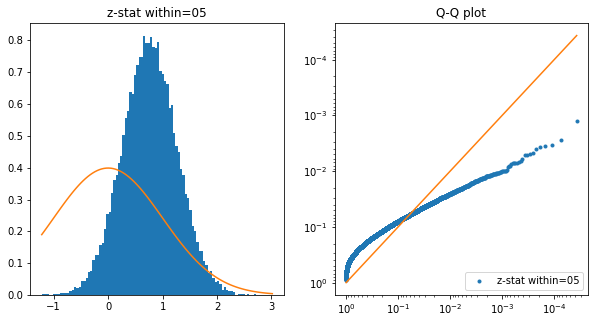

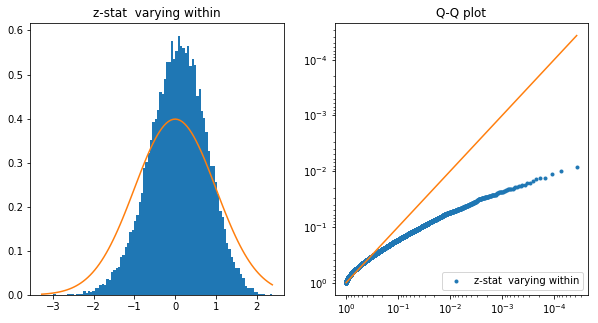

In [4]:
hier_wth05_n20 = '/Volumes/camille/IBMA_simu_hier_noperm/test1_k025_n20_btw1_wth025_nominal/0001/megaMFX/'
hier_wthdiff_n20 = '/Volumes/camille/IBMA_simu_hier_noperm/test1_k025_n20_btw1_wthdiff_nominal/0001/megaMFX/'
hier_z_05 = nib.load(os.path.join(hier_wth05_n20, 'stats', 'zstat1.nii.gz')).get_data().flatten()
hier_z_diff = nib.load(os.path.join(hier_wthdiff_n20, 'stats', 'zstat1.nii.gz')).get_data().flatten()

z_distribution_plot(hier_z_05, 'z-stat within=05')
z_distribution_plot(hier_z_diff, 'z-stat  varying within')

In [5]:
N = 20;
K = 25;
copes = dict()
varcopes = dict()
sigma2 = 0.5
tau2 = 1

for i in ['050']:
    key = 'wth' + str(i) + '_k' + str(K) + '_n' + str(N)
    print('key is \'' + key + '\'')
    study_dir = '/Volumes/camille/IBMA_simu_hier_noperm/test1_k0' + str(K) + '_n' + str(N) + '_btw1_wth' + i + '_nominal/0001/megaMFX/'
    copes[key] = nib.load(os.path.join(study_dir, 'cope.nii.gz')).get_data().reshape(-1,K)
    varcopes[key] = nib.load(os.path.join(study_dir, 'varcope.nii.gz')).get_data().reshape(-1,K)

# Check mean/variance of input copes
print('Mean of study 1 cope = ' + str(np.mean(copes[key][:,0].flatten())))
print('Variance of study 1 cope = ' + str(np.var(copes[key][:,0].flatten())))
print('----')

study_means = []
study_vars = []
for k in range(1,K+1):
    study_means.append(np.mean(copes[key][:,k-1].flatten()))
    study_vars.append(np.var(copes[key][:,k-1].flatten()))
    
print('Mean of cope by study ' + str(study_means))
print('Variance of cope by study ' + str(study_vars))
print('----')

print('Mean of copes mean = ' + str(np.mean(study_means)))
th_var_mean_of_cope_mean = (sigma2/30/30/30+tau2)/K
th_sterr_mean_of_cope_mean = np.sqrt(th_var_mean_of_cope_mean)
print('95% CI of copes mean = [' + str(0-1.96*th_sterr_mean_of_cope_mean) + ';' + str(0+1.96*th_sterr_mean_of_cope_mean) + ']')

print('Mean of cope variances = ' + str(np.mean(study_vars))) 

key is 'wth050_k25_n20'
Mean of study 1 cope = -0.645314
Variance of study 1 cope = 0.502549
----
Mean of cope by study [-0.6453138, -1.9651363, 0.61670053, 0.25893015, -0.48126698, 0.76034194, 0.60965872, 1.1794585, 1.0322201, 0.41849878, -0.9788962, 0.77487445, 0.18436077, 0.45012474, 0.94050258, -0.89098489, 0.04371753, 1.3615136, 0.76612145, -1.1173202, -1.1871814, 0.41935673, -0.26872668, 0.89457047, 0.67701352]
Variance of cope by study [0.50254864, 0.50675458, 0.49937481, 0.50573826, 0.49858788, 0.50787121, 0.49712619, 0.50162977, 0.49614671, 0.49984249, 0.49881524, 0.50212044, 0.50096744, 0.50199074, 0.49719363, 0.51010084, 0.50500649, 0.49791348, 0.49873069, 0.50164574, 0.49607348, 0.49532732, 0.49821734, 0.49326324, 0.50155628]
----
Mean of copes mean = 0.154126
95% CI of copes mean = [-0.392003629613;0.392003629613]
Mean of cope variances = 0.500582


### Matlab code showing the equivalence (as long as study_mean is defined independently across voxels)

```
clear all;
nsub = 20;
kstudies = 25;
% Degrees of freedom of the within-study variance estimate
dof = nsub-1;
btw_sigma = 1;
wth_sigma_a = repmat([1 2 4 8 16], 1, kstudies); % constant within subject variance
wth_sigma_a = wth_sigma_a(1:kstudies);
nrep = 1000;
sigma_sq = 0.25*nsub;
nvoxels = 10000;

% for iter = 1:10000
for i = 1:kstudies
    % Study-specific mean effect
    study_mean(:, i) = normrnd(0, sqrt(btw_sigma), nvoxels, 1);

    % Estimated paramater estimate.
    estimatedContrast(:, i) = normrnd(study_mean(:, i), repmat(sqrt(sigma_sq*wth_sigma_a(i)./nsub), nvoxels, 1));

    estimatedContrast_orig(:, i) = normrnd(0, sqrt(sigma_sq*wth_sigma_a(i)./nsub+btw_sigma), nvoxels, 1);
end
% end

study_est = mean(estimatedContrast,2);
study_est_origin = mean(estimatedContrast_orig,2);

figure(1);hist(study_est, 100)
title('hierarchical estimate');
figure(2);hist(study_est_origin, 100);
title('non hierarchical estimate');

% Compare to theoretical normal distribution
% study_est_th ~ N(0, (sigma_^2/n + tau^2)/kstudies)
% study_est./sqrt()
```